In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.scipy.special import expit as sigmoid

from autograd import grad
from autograd.misc.optimizers import adam
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_nichols_data
import zimmer.plotting as zplt
from zimmer.util import cached

from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Specify hyperparameters
D = 10   # dimensionality of continuous latent states
M = 0    # dimensionality of input
results_dir = "results/nichols/2018-09-19".format(D)

In [3]:
worms_and_conditions = [(i, "n2_1_prelet") for i in range(11)] + \
                       [(i, "n2_2_let") for i in range(12)] + \
                       [(i, "npr1_1_prelet") for i in range(10)] + \
                       [(i, "npr1_2_let") for i in range(11)]
worm_names = ["{} worm {}".format(condition, i) for (i, condition) in worms_and_conditions]

groups = np.concatenate([
    0 * np.ones(11, dtype=int),
    1 * np.ones(12, dtype=int),
    2 * np.ones(10, dtype=int),
    3 * np.ones(11, dtype=int)
])

In [4]:
# Load the data
ys, ms, us, z_trues, z_true_key, neuron_names = load_nichols_data(worms_and_conditions, worm_names, include_unnamed=False, signal="dff")

Only including named neurons.
73 neurons across all 44 worms


In [5]:
ys = [trend_filter(y) for y in ys]
# ys = [standardize(y, m) for y, m in zip(ys, ms)]
K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

In [6]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_ms = []
all_us = []
all_gs = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, m, u, g, ztr) in enumerate(zip(ys, ms, us, groups, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_ms.append(m[start:stop])
        all_us.append(u[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_gs.append(g)
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_ms = get(all_ms, 0)
train_us = get(all_us, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_gs, 0)
# train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_ms = get(all_ms, 1)
val_us = get(all_us, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_gs, 1)
# val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_ms = get(all_ms, 2)
test_us = get(all_us, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_gs, 2)
# test_tags = get(all_tags, 2)

# Nonlinear factor analysis

In [7]:
Ds = np.arange(2, 21, 2)

In [8]:
def relu(x):
    return np.maximum(0, x)

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def reconstruct(z, thetas):
    # Pass z through neural network to get E[x | z]
    inputs = z
    for W, b in thetas[:-1]:
        outputs = batch_normalize(np.dot(inputs, W) + b)  # linear transformation
        # inputs = relu(outputs)                            # nonlinear transformation
        inputs = np.tanh(outputs)

    # No batch norm on the last layer
    outW, outb = thetas[-1]
    return np.dot(inputs, outW) + outb

def gaussian_entropy(log_std):
    return 0.5 * log_std.size * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

def kl_gaussian(mu1, logstd1, mu2, logstd2):
    return logstd2 - logstd1 + (np.exp(2 * logstd1) + (mu1 - mu2)**2) / (2 * np.exp(2 * logstd2)) - 0.5

def nelbo(datas, masks, params, itr):
    """
    -E_q(z; phi)[log p(x, z; theta) - log q(z; phi)]
    """
    phis, thetas = params
    
    elbo = 0
    T = 0
    for data, mask, (q_mu, q_logstd) in zip(datas, masks, phis):
        # Sample q(z; phi)
        z = q_mu + npr.randn(*q_mu.shape) * np.exp(q_logstd)
        
        # Compute -log q(z; phi)
        elbo -= np.sum(norm.logpdf(z, q_mu, np.exp(q_logstd)))
        # elbo += gaussian_entropy(q_logstd)
        # elbo -= np.sum(-0.5 * np.log(2 * np.pi) - q_logstd -0.5 * ((z - q_mu) / np.exp(q_logstd))**2)        
        
        # Compute log p(z; theta)
        elbo += np.sum(norm.logpdf(z, 0.0, 1.0))
        # elbo += np.sum(-0.5 * np.log(2 * np.pi) -0.5 * z**2)
        
        # Compute -KL(q || p) 
        # elbo -= np.sum(kl_gaussian(q_mu, q_logstd, 0, 0))
        
        # Compute log p(x | z; theta)
        p_mu = reconstruct(z, thetas)
        elbo += np.sum(norm.logpdf(data[mask], p_mu[mask], np.sqrt(0.006)))
        
        # Update T 
        T += data.shape[0]
    
    return -elbo / T / N

def initialize_phis(D, datas):
    phis = []
    for data in datas:
        T = data.shape[0]
        q_mu = 0 * npr.randn(T, D)
        q_logstd = -2 * np.ones((T, D))
        phis.append((q_mu, q_logstd))
        
    return phis

def initialize_thetas(scale, layer_sizes):
    """Build a (weights, biases) tuples for all layers."""
    return [(scale * npr.randn(m, n),   # weight matrix
             scale * npr.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

In [9]:
def fit_nonlinear_fa(D=10, hidden_layer_sizes=()):

    init_phis = initialize_phis(D, train_ys)
    layer_sizes = (D,) + hidden_layer_sizes + (N,)
    init_thetas = initialize_thetas(.1, layer_sizes)
    combined_init_params = (init_phis, init_thetas)
    objective = partial(nelbo, train_ys, train_ms)

    print("     Iter      |    Objective       |")
    losses = []
    def print_perf(combined_params, itr, grad):
        if itr % 1 == 0:
            loss = np.mean(objective(combined_params, itr))
            losses.append(loss)
            message = "{:15}|{:20}|".format(itr, loss)
            print(message)

    optimized_params = adam(grad(objective), combined_init_params, step_size=.01,
                            num_iters=2000, callback=print_perf)
    
    return optimized_params, np.array(losses)

In [10]:
# Fit the linear model with varaiational inference
results = {}
for D in Ds:
    results_name = "fa_D{}".format(D)
    print("Fitting ", results_name)
    _fit = cached(results_dir, results_name)(fit_nonlinear_fa)
    results[results_name] = _fit(D=D, hidden_layer_sizes=())

Fitting  fa_D2
Fitting  fa_D4
Fitting  fa_D6
Fitting  fa_D8
Fitting  fa_D10
Fitting  fa_D12
Fitting  fa_D14
Fitting  fa_D16
Fitting  fa_D18
Fitting  fa_D20


In [11]:
# Fit the nonlinear model with variational inference
H = 50
for D in Ds:
    results_name = "nfa_D{}_H{}".format(D, H)
    print("Fitting ", results_name)
    _fit = cached(results_dir, results_name)(fit_nonlinear_fa)
    results[results_name] = _fit(D=D, hidden_layer_sizes=(H,))

Fitting  nfa_D2_H50
     Iter      |    Objective       |
              0|   2.182967334036624|
              1|  2.1234531350585524|


KeyboardInterrupt: 

# Evaluate the models with the marginal likelihood of heldout data

For the models are linear, we can compute the marginal probability $p(y | C, d)$ where $C, d$ are the weights and biases of the single layer.  We have

$$ y \sim \mathcal{N}(d, CC^\mathsf{T} + \sigma^2 I)$$

where $\sigma^2 = 0.006$ from the code above.  Marginalization is easy: we just grab the required blocks of $d$ and $(CC^{\mathsf{T}} + \sigma^2 I)$.

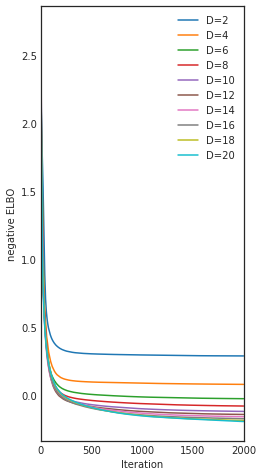

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
for D in Ds:
    _, losses = results["fa_D{}".format(D)]
    plt.plot(np.arange(0,2000), losses, label="D={}".format(D))
plt.xlim(0, 2000)
plt.xlabel("Iteration")
plt.ylabel("negative ELBO")
plt.legend(loc="upper right")
yl = plt.ylim()

# plt.subplot(122)
# for D in Ds:
#     _, losses = results["nfa_D{}_H{}".format(D, H)]
#     plt.plot(np.arange(0,2000), losses, label="D={} H={}".format(D, H))
# plt.xlim(0, 2000)
# plt.xlabel("Iteration")
# plt.ylabel("negative ELBO")
# plt.legend(loc="upper right")
# plt.ylim(yl)


In [15]:
def true_val_likelihood(D):
    (optimized_phis, [(CT, d)]), losses = results["fa_D{}".format(D)]
    
    # Compute validation likelihood
    Sigma = np.dot(CT.T, CT) + 0.006 * np.eye(N)
    ll = 0
    T = 0
    for y, m in zip(val_ys, val_ms):
        inds = np.where(m[0])[0]
        ll += mvn.logpdf(y[:,inds], d[inds], Sigma[np.ix_(inds, inds)]).sum()
        T += y.shape[0]

    return ll / T / N

In [18]:
# Now estimate the validation likelihood with the ELBO
def val_nelbo(val_ys, val_ms, thetas, phis, itr):
    return nelbo(val_ys, val_ms, (phis, thetas), itr)

def estimate_val_nelbo(D, thetas):

    init_phis = initialize_phis(D, val_ys)
    objective = partial(val_nelbo, val_ys, val_ms, thetas)

    print("     Iter      |    Objective       |")
    losses = []
    def print_perf(phis, itr, grad):
        if itr % 100 == 0:
            loss = np.mean(objective(phis, itr))
            losses.append(loss)
            message = "{:15}|{:20}|".format(itr, loss)
            print(message)

    optimized_params = adam(grad(objective), init_phis, step_size=.01,
                            num_iters=1000, callback=print_perf)
    
    return optimized_params, np.array(losses)

In [ ]:
validation = {}
for D in Ds:
    # Linear FA
    results_name = "fa_D{}".format(D)
    (_, thetas), losses = results[results_name]
    
    print("Validating ", results_name)
    _val = cached(results_dir, results_name + "_val")(estimate_val_nelbo)
    validation[results_name] = _val(D, thetas)
    
#     # Nonlinear FA
#     results_name = "nfa_D{}_H{}".format(D, H)
#     (_, thetas), losses = results[results_name]
    
    print("Validating ", results_name)
    _val = cached(results_dir, results_name + "_val")(estimate_val_nelbo)
    validation[results_name] = _val(D, thetas)

Validating  fa_D2
     Iter      |    Objective       |
              0|  1.8267209081622613|
            100|  0.5531029727906657|
            200| 0.36063569909306764|
            300| 0.30659944387666155|
            400| 0.28812321740510277|
            500|  0.2813913789718575|
            600| 0.27866819789245334|
            700|  0.2775951747214516|
            800|  0.2772304379990171|
            900|  0.2768028204958801|
Validating  fa_D2
Validating  fa_D4
     Iter      |    Objective       |
              0|  1.8491688233881194|
            100| 0.44663648912327597|
            200| 0.21564843248559237|
            300|  0.1460377738161574|
            400| 0.12025647627702234|
            500|  0.1099306874961721|
            600| 0.10531951427706338|
            700| 0.10335940828471168|
            800| 0.10241149147221944|
            900| 0.10209677137911408|
Validating  fa_D4
Validating  fa_D6
     Iter      |    Objective       |
              0|   1.881144370221275

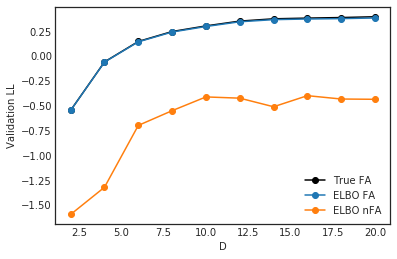

In [17]:
true_lls = [true_val_likelihood(D) for D in Ds]
fa_elbos = [-1 * validation["fa_D{}".format(D)][1][-1] for D in Ds]
nfa_elbos = [-1 * validation["nfa_D{}_H{}".format(D, H)][1][-1] for D in Ds]

plt.plot(Ds, true_lls, '-ko', label="True FA")
plt.plot(Ds, fa_elbos, '-o', label="ELBO FA")
plt.plot(Ds, nfa_elbos, '-o', label="ELBO nFA")
plt.xlabel("D")
plt.ylabel("Validation LL")
plt.legend(loc="lower right")

In [ ]:
plt.plot(Ds, np.array(true_lls) - np.array(fa_elbos))
plt.xlabel("D")
plt.ylabel("Gap")
plt.title("Approx. Gap (Linear FA)")

# Check that the learned linear model spans the same subspace as PCA

In [18]:
D = 10
(_, [(CT, d)]), losses = results["fa_D{}".format(D)]
Sigma = np.dot(CT.T, CT) + 0.006 * np.eye(N)
evals, evecs = np.linalg.eigh(Sigma, )
inds = np.argsort(evals)[::-1][:D]
Cstar = evecs[:, inds]

In [19]:
# Find the linear transformation that maps C to Cstar
#    Cstar = C \dot R
#    Cstar R^{-1} = C
#    y = Cx = Cstar R^{-1} x
R, _, _, _ = np.linalg.lstsq(CT.T, Cstar)
Ri = np.linalg.inv(R)

/home/scott/Projects/autograd/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


In [20]:
# Run PCA with imputation for comparison
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(10, ys, ms)
Cpca = pca.components_.T

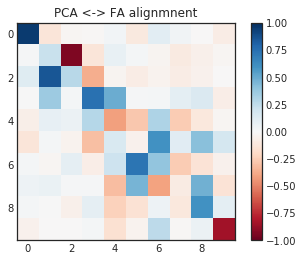

In [21]:
plt.figure()
plt.imshow(np.dot(Cpca.T, Cstar), vmin=-1, vmax=1, cmap="RdBu")
plt.title("PCA <-> FA alignmnent")
plt.colorbar()

Text(0,0.5,'dim 3')

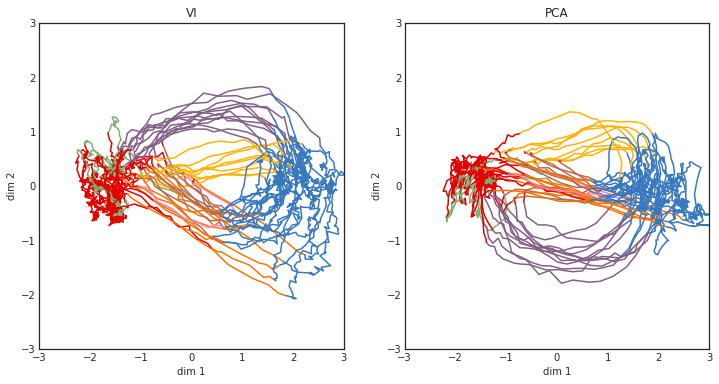

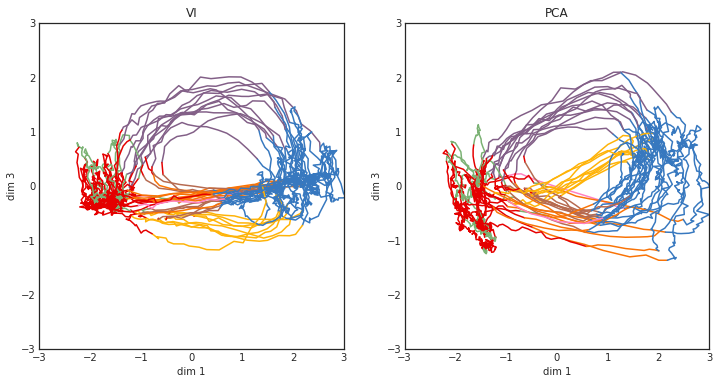

In [22]:
D = 10
results_name = "fa_D{}".format(D)
(phis, thetas), losses = results[results_name]
xs_vi = [q_mu for q_mu, q_logstd in phis]
xs_vi = [x.dot(Ri.T) for x in xs_vi]

w = 4
plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
zplt.plot_2d_continuous_states(xs_vi[w], z_trues[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 1), ax=ax)
plt.title("VI")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
ax = plt.subplot(122)
zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 1), ax=ax)
plt.title("PCA")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
zplt.plot_2d_continuous_states(xs_vi[w], z_trues[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 2), ax=ax)
plt.title("VI")
plt.xlabel("dim 1")
plt.ylabel("dim 3")
ax = plt.subplot(122)
zplt.plot_2d_continuous_states(xs[w], z_trues[w], xlims=(-3, 3), ylims=(-3, 3), inds=(0, 2), ax=ax)
plt.title("PCA")
plt.xlabel("dim 1")
plt.ylabel("dim 3")